# Processing a run

In [1]:
# standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# the main package
import pylars

# plot functions
from pylars.plotting.plotwaveforms import *
from pylars.plotting.plotprocessed import *

# specific sub-mudules for waveform and channel processing
from pylars.processing.waveforms import *
from pylars.processing.pulses import *
from pylars.processing.rawprocessor import *

In [2]:
# Create processor
process = pylars.processing.rawprocessor.simple_processor(sigma_level=5, baseline_samples=50)

In [3]:
#Load the raw data into the processor
data_path = '/disk/gfs_atp/xenoscope/SiPMs/char_campaign/raw_data/run6/data/BV_185K_50_00V/Module0/BV_185K_50_00V_Module_0_0.root'
process.load_raw_data(data_path, 50.0,185, module = 0)

In [4]:
process.raw_data.channels

['wf0', 'wf2', 'wf3', 'wf4', 'wf5', 'wf6']

### Take a look at waveforms

In [5]:
channel_data = process.raw_data.get_channel_data('wf0')
print(f'Found {len(channel_data)} waveforms.')

Found 50000 waveforms.


In [6]:
np.shape(channel_data)

(50000, 700)

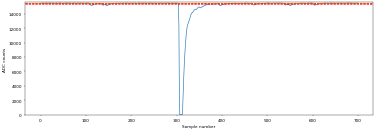

In [7]:
fig, ax = plt.subplots(1,1,figsize = (15,5), dpi = 30)
ax = plot_waveform(channel_data[49999], ax = ax)
plt.show()

### Process by hand

In [8]:
_waveform = np.array(channel_data[7])

baseline = waveform_processing.get_baseline_rough(_waveform, 50) 
std = waveform_processing.get_std_rough(_waveform, 50)
pks = pulse_processing.find_pulses_simple(_waveform, baseline, std, 5)

In [9]:
pks = pulse_processing.find_pulses_simple(np.array(channel_data[0]), baseline, std, 2)

In [10]:
_waveform = np.array(channel_data[0])
print(f'Computed baseline: {baseline}.\nComputed RMS: {std}.')
print(f'Identified pulses: {pks}')

Computed baseline: 15490.0.
Computed RMS: 12.043736961591282.
Identified pulses: [array([0, 1]), array([3, 4, 5, 6]), array([10, 11]), array([34]), array([159, 160, 161]), array([247]), array([280, 281]), array([288]), array([305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421]), array([426, 427, 428]), array([433]), array([435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
       448, 449, 450,

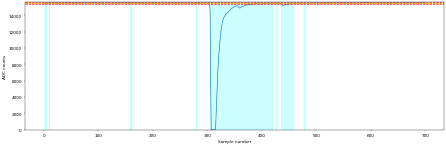

In [11]:
fig, ax = plt.subplots(1,1, figsize = (15,5), dpi = 30)
ax = plot_pulses(_waveform, pks, ax = ax)
plt.tight_layout()
plt.show()

In [12]:
areas, lengths, positions, amplitudes = waveform_processing.process_waveform(np.array(channel_data[7]), 
                                                                             process.baseline_samples, 
                                                                             process.sigma_level)
print(f'Computed areas: {areas}\nComputed amplitudes: {amplitudes}')

Computed areas: [2422780.   36570.   26910.   40890.]
Computed amplitudes: [    0. 15154. 15207. 15112.]


### Full channel

In [13]:
results_ch0 = pd.DataFrame(process.process_channel('wf0'))

Processing module 0 channel wf0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 10596.81it/s]


In [14]:
results_ch0.head()

,module,channel,wf_number,pulse_number,area,length,position,amplitude
0,0,wf0,0,0,2661080.0,85,305,0.0
1,0,wf0,0,1,0.0,1,394,15483.5
2,0,wf0,0,2,1880.0,3,397,15384.0
3,0,wf0,0,3,25350.0,15,436,15194.0
4,0,wf0,1,0,20910.0,13,142,15221.0


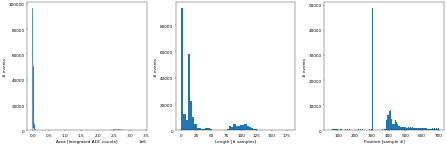

In [15]:
fig, axs = plt.subplots(1,3, figsize = (15,5), dpi = 30)
plot_3hists(results_ch0, axs = axs)
plt.tight_layout()
plt.show()

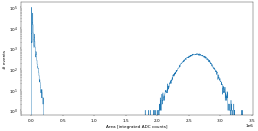

In [16]:
fig, ax = plt.subplots(1,1, figsize = (10,5), dpi = 30)
ax = plot_hist_area(results_ch0,ax = ax)

ax.set_yscale('log')
plt.show()

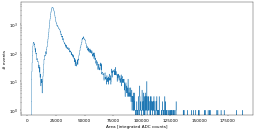

In [17]:
## Is it a fingerplot of afterpulses on the left?
cut_mask = ((results_ch0['length'] > 7) &
            (results_ch0['length'] < 30) &
            (results_ch0['area'] < 0.5e6)
#             (results_ch0['position'] > 280) &
#             (results_ch0['position'] < 400)
           )

fig, ax = plt.subplots(1,1, figsize = (10,5), dpi = 30)
ax = plot_hist_area(results_ch0[cut_mask],ax = ax)

ax.set_yscale('log')
plt.show()